In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 45, 65] # longitude min, longitude max, latitude min, latitude max
northsea = [-17, 20, 40, 70]

# Regridding

In [3]:
# PGW ens members
pgw_ens = bb.data.Data.get_pgw_ensemble()
pgw_ens['tp'] = (((pgw_ens.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time')))*3/24

Importing data from pre-existing file


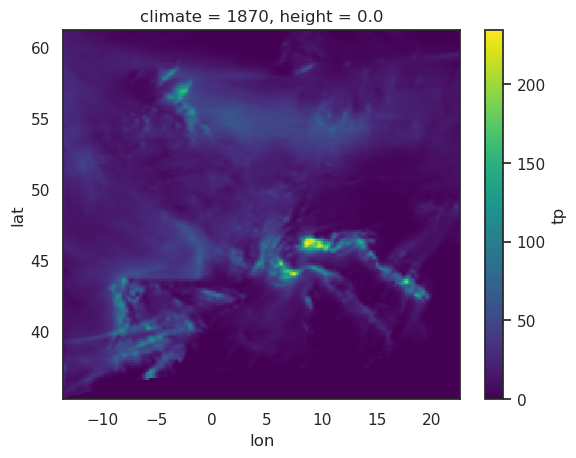

In [4]:
pgw_ens.tp.sel(climate='1870').mean('member').plot(vmin=0)

In [5]:
tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc').expand_dims(climate=["1870"])
var_name = "unknown"

slp_vars = sorted([var for var in tmp1.data_vars if var.startswith(var_name)])

# Stack all precipitation variables along the new 'member' dimension
msl = xr.concat([tmp1[var] for var in slp_vars], dim="member")

# Assign member values from 1 to 27
msl = msl.assign_coords(member=np.arange(1, len(slp_vars) + 1))

# Create a new dataset with the combined variable
test = xr.Dataset({var_name: msl}, coords={"rlat": tmp1.rlat, "rlon": tmp1.rlon, "member": msl.member, "time": tmp1.time})

tmp1_ = xr.Dataset(
    {var_name: (("member", "climate", "time", "lat", "lon"), msl.values)},
    coords={
        "lat": test.lat.values[:, 0],
        "lon": test.lon.values[0, :],
        "time": test.time.values,
        "member": test.member.values,
        "climate": test.climate.values,
    }
).rename({"unknown": "tp"})

In [6]:
tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc').expand_dims(climate=["1870"])
var_name = "unknown"

slp_vars = sorted([var for var in tmp1.data_vars if var.startswith(var_name)])

# Stack all precipitation variables along the new 'member' dimension
msl = xr.concat([tmp1[var] for var in slp_vars], dim="member")

# Assign member values from 1 to 27
msl = msl.assign_coords(member=np.arange(1, len(slp_vars) + 1))

# Create a new dataset with the combined variable
test = xr.Dataset({var_name: msl}, coords={"rlat": tmp1.rlat, "rlon": tmp1.rlon, "member": msl.member, "time": tmp1.time})

tmp1_ = xr.Dataset(
    {var_name: (("member", "climate", "time", "lat", "lon"), msl.values)},
    coords={
        "lat": test.lat.values[:, 0]+2.8, ## Grid seems rotated
        "lon": test.lon.values[0, :]-2.8,
        "time": test.time.values,
        "member": test.member.values,
        "climate": test.climate.values,
    }
).rename({"unknown": "tp"})
tmp1_['tp'] = (((tmp1_.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time')))/3*24

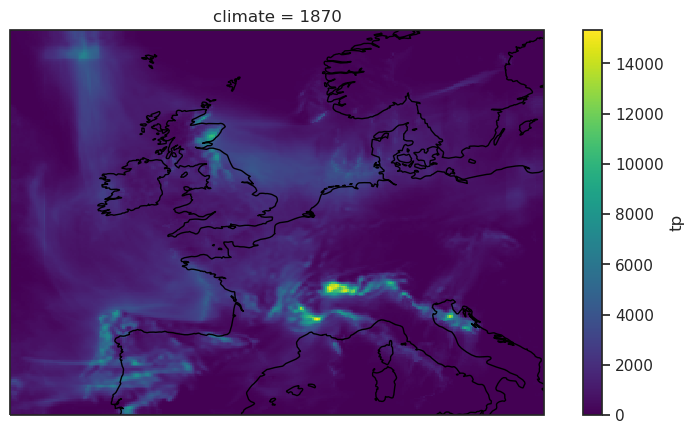

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
tmp1_.mean('member').max('time').squeeze().tp.plot(ax=ax)
ax.coastlines()

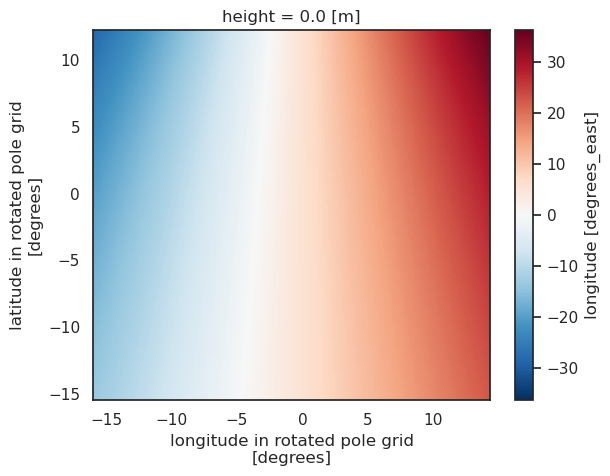

In [8]:
tmp1.lon.plot()

# Need to regrid the rotated pole grid

In [9]:
import iris
import iris.coord_systems as cs
import iris.coords as icoords
import numpy as np

# Load your cube
cube = iris.load('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc')

In [10]:
lat_vals = cube[0].coord('latitude').points[:,0]
lon_vals = cube[0].coord('longitude').points[0,:]

# Create coordinate system: regular geographic
coord_sys = cs.GeogCS(6371229)  # Or use None if you want to go coord-less

# Create DimCoords with the coord system
latitude = icoords.DimCoord(lat_vals, standard_name='latitude', units='degrees',
                            coord_system=coord_sys)
longitude = icoords.DimCoord(lon_vals, standard_name='longitude', units='degrees',
                             coord_system=coord_sys)

# Build dummy target cube
target_cube = iris.cube.Cube(np.zeros((len(lat_vals), len(lon_vals))),
                             dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

In [11]:
regridded = cube[0].regrid(target_cube, iris.analysis.Linear())

In [12]:
xr_regrid = xr.DataArray.from_iris(regridded)
tmp1_ = (((xr_regrid.rename('tp').sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time')))

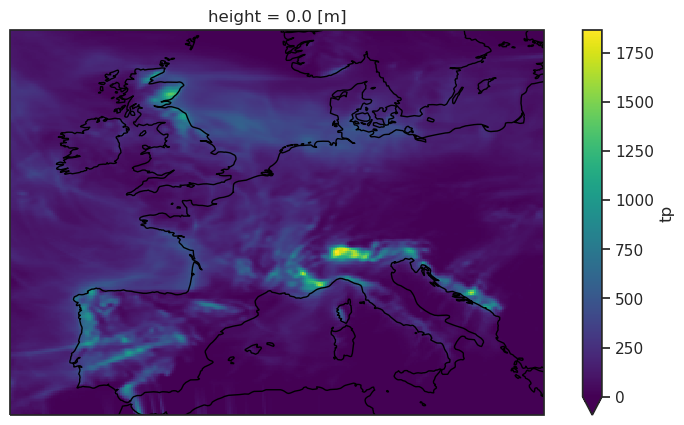

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
tmp1_.plot(ax=ax, vmin=0)
ax.coastlines()

# Regrid using xarray and xesmf

In [14]:
import xesmf as xe
ds = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc')

In [15]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], ds.lat[:,0].values),
        "lon": (["lon"], ds.lon[0,:].values),
    }
)

regridder = xe.Regridder(ds, ds_out, "bilinear")

In [16]:
regridded_data = regridder(ds)
tmp1_ = (((regridded_data.unknown.rename('tp').sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time')))

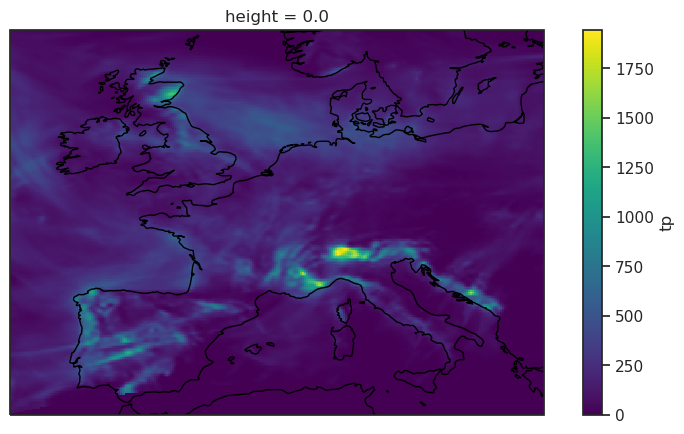

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
tmp1_.plot(ax=ax, vmin=0)
ax.coastlines()

In [18]:
def regrid_racmo(ds):
    import xesmf as xe
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], ds.lat[:,0].values),
            "lon": (["lon"], ds.lon[0,:].values),
        }
    )

    regridder = xe.Regridder(ds, ds_out, "bilinear")

    regridded_data = regridder(ds)
    return regridded_data


In [19]:
test = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc')
regrid_racmo(test) # need to insert this function into clean_array_racmo function 

<xarray.Dataset>
Dimensions:    (time: 24, lat: 252, lon: 276)
Coordinates:
  * time       (time) datetime64[ns] 2023-10-19 ... 2023-10-21T21:00:00
    height     float64 ...
  * lat        (lat) float64 35.24 35.35 35.45 35.56 ... 60.87 60.97 61.07 61.17
  * lon        (lon) float64 -13.47 -13.34 -13.22 -13.09 ... 22.25 22.37 22.5
Data variables:
    unknown    (time, lat, lon) float32 0.1875 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    unknown_0  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    unknown_1  (time, lat, lon) float32 0.5 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    unknown_2  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [20]:
import os
def clean_array_racmo(tmp1, var_name):
    # Find all variables that start with "unknown"
    slp_vars = sorted([var for var in tmp1.data_vars if var.startswith(var_name)])

    # Stack all precipitation variables along the new 'member' dimension
    msl = xr.concat([tmp1[var] for var in slp_vars], dim="member")

    # Assign member values from 1 to 27
    msl = msl.assign_coords(member=np.arange(1, len(slp_vars) + 1))

    # Create a new dataset with the combined variable
    test = xr.Dataset({var_name: msl}, coords={"rlat": tmp1.rlat, "rlon": tmp1.rlon, "member": msl.member, "time": tmp1.time})

    tmp1_ = regrid_racmo(test)
    return tmp1_

def get_pgw_ensemble():
        # check if file exists
        if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_clean_ensemble.nc'):
            # mean sea level pressure
            tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGW+1.nc').expand_dims(climate=["1870"])
            tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_CTL.nc').expand_dims(climate=["present"])
            tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGW+1.nc').expand_dims(climate=["future1"])
            
            tmp4dry = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGWdry+3.nc').expand_dims(dummy=["dry"])
            tmp4wet = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGWwet+3.nc').expand_dims(dummy=["wet"])
            tmp4 = xr.concat([tmp4dry, tmp4wet], dim="dummy").mean("dummy").squeeze().expand_dims(climate=["future2"])

            tmp1_ = clean_array_racmo(tmp1, var_name="msl")
            tmp2_ = clean_array_racmo(tmp2 , var_name="msl")
            tmp3_ = clean_array_racmo(tmp3, var_name="msl")
            tmp4_ = clean_array_racmo(tmp4, var_name="msl")
            pgw_ens = xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate")

            # precip
            tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc').expand_dims(climate=["1870"])
            tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_CTL.nc').expand_dims(climate=["present"])
            tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW+1.nc').expand_dims(climate=["future1"])
            
            tmp4dry = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGWdry+3.nc').expand_dims(dummy=["dry"])
            tmp4wet = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGWwet+3.nc').expand_dims(dummy=["wet"])
            tmp4 = xr.concat([tmp4dry, tmp4wet], dim="dummy").mean("dummy").squeeze().expand_dims(climate=["future2"])

            tmp1_ = clean_array_racmo(tmp1, var_name="unknown")
            tmp2_ = clean_array_racmo(tmp2, var_name="unknown")
            tmp3_ = clean_array_racmo(tmp3, var_name="unknown")
            tmp4_ = clean_array_racmo(tmp4, var_name="unknown")
            pgw_ens = xr.merge([pgw_ens, 
                                xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate").rename({"unknown": "tp"})], 
                                compat="override")
            
            # temperature
            tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGW-1.nc').expand_dims(climate=["1870"])
            tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_CTL.nc').expand_dims(climate=["present"])
            tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGW+1.nc').expand_dims(climate=["future1"])
            
            tmp4dry = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGWdry+3.nc').expand_dims(dummy=["dry"])
            tmp4wet = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGWwet+3.nc').expand_dims(dummy=["wet"])
            tmp4 = xr.concat([tmp4dry, tmp4wet], dim="dummy").mean("dummy").squeeze().expand_dims(climate=["future2"])
            
            tmp1_ = clean_array_racmo(tmp1, var_name="t2m")
            tmp2_ = clean_array_racmo(tmp2, var_name="t2m")
            tmp3_ = clean_array_racmo(tmp3, var_name="t2m")
            tmp4_ = clean_array_racmo(tmp4, var_name="t2m")
            pgw_ens = xr.merge([pgw_ens, 
                                xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate")], 
                                compat="override")

            # Save to netcdf
            # pgw_ens.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_clean_ensemble.nc')
        else:
            print('Importing data from pre-existing file')
            pgw_ens = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_clean_ensemble.nc')

        return pgw_ens

In [21]:
pgw = get_pgw_ensemble()

Importing data from pre-existing file


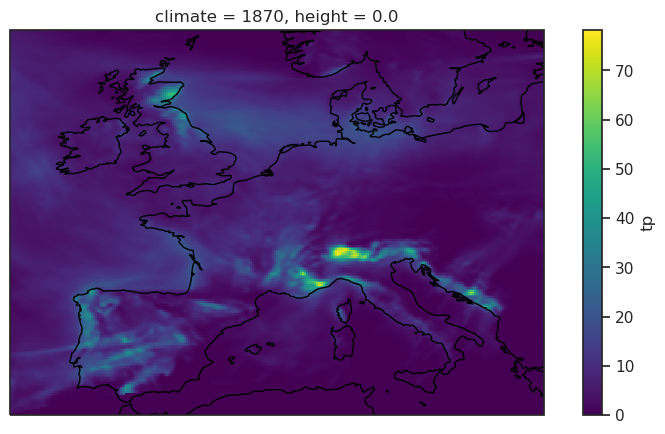

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
(pgw.tp.sel(climate='1870', time=slice('2023-10-19 00', '2023-10-22 00')).mean('member').sum('time').squeeze()/24).plot(ax=ax, vmin=0)
ax.coastlines()

# Need to regrid RACMO analogues?

In [28]:
tmp = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_RACMO__precip__2071-2100_3dy_ave.nc')

The precip files seem to need regridding while the mslp files are already on a regular grid

In [30]:
regrid_racmo(tmp)

<xarray.Dataset>
Dimensions:  (time: 432, lat: 194, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 2023-10-20T11:00:00 ... 2023-10-20T11:00:00
    ens      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 16 16 16 16 16 16 16 16 16 16
    ana      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24 25 26
  * lat      (lat) float64 40.95 41.06 41.16 41.27 ... 60.92 61.02 61.12 61.23
  * lon      (lon) float64 -11.7 -11.56 -11.42 -11.28 ... 16.83 16.97 17.11
Data variables:
    precip   (time, lat, lon) float32 1.713e-06 0.0 0.0 ... 6.004e-05 5.932e-05
Attributes:
    regrid_method:  bilinear

In [31]:
tmp

<xarray.Dataset>
Dimensions:  (time: 432, rlat: 194, rlon: 200)
Coordinates:
  * time     (time) datetime64[ns] 2023-10-20T11:00:00 ... 2023-10-20T11:00:00
    lon      (rlat, rlon) float64 -11.7 -11.56 -11.42 ... 24.05 24.27 24.5
    lat      (rlat, rlon) float64 40.95 40.98 41.0 41.03 ... 62.63 62.6 62.57
  * rlon     (rlon) float64 -13.08 -12.97 -12.86 -12.75 ... 8.48 8.59 8.7 8.81
  * rlat     (rlat) float64 -10.24 -10.13 -10.02 -9.91 ... 10.77 10.88 10.99
    ens      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 16 16 16 16 16 16 16 16 16 16
    ana      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24 25 26
Data variables:
    precip   (time, rlat, rlon) float32 ...

# Factor for PGW data

In [4]:
pgw_ens = bb.data.Data.get_pgw_ensemble()

Importing data from pre-existing file


In [5]:
pgw_ens.time.values

array(['2023-10-19T00:00:00.000000000', '2023-10-19T03:00:00.000000000',
       '2023-10-19T06:00:00.000000000', '2023-10-19T09:00:00.000000000',
       '2023-10-19T12:00:00.000000000', '2023-10-19T15:00:00.000000000',
       '2023-10-19T18:00:00.000000000', '2023-10-19T21:00:00.000000000',
       '2023-10-20T00:00:00.000000000', '2023-10-20T03:00:00.000000000',
       '2023-10-20T06:00:00.000000000', '2023-10-20T09:00:00.000000000',
       '2023-10-20T12:00:00.000000000', '2023-10-20T15:00:00.000000000',
       '2023-10-20T18:00:00.000000000', '2023-10-20T21:00:00.000000000',
       '2023-10-21T00:00:00.000000000', '2023-10-21T03:00:00.000000000',
       '2023-10-21T06:00:00.000000000', '2023-10-21T09:00:00.000000000',
       '2023-10-21T12:00:00.000000000', '2023-10-21T15:00:00.000000000',
       '2023-10-21T18:00:00.000000000', '2023-10-21T21:00:00.000000000',
       '2023-10-22T00:00:00.000000000'], dtype='datetime64[ns]')

In [12]:
pgw_ens_tp = (((pgw_ens.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))).sum(dim='time')))/24*3

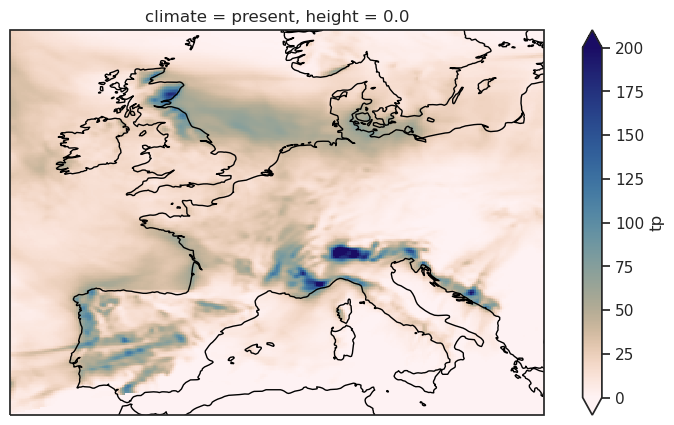

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
pgw_ens_tp.sel(climate='present').mean('member').plot(vmin=0, vmax=200, ax=ax, cmap=cm.lapaz_r)
ax.coastlines()

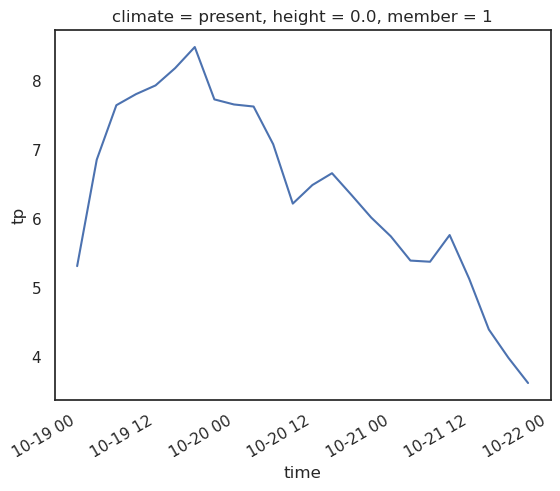

In [ ]:
pgw_ens.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'), member=1, climate='present').mean(dim=['lat', 'lon']).plot()